# First NN with torch 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [2]:
# Data upload
file_path = "data/voice.csv"
data = pd.read_csv(file_path)
data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values
y = data['label'].values

In [3]:
# Pre-processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [7]:
# Creation of the Neural Network 
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_1, hidden_layer_2, use_batch_norm=True, noise_scale=0.0):
        super(NeuralNetwork, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.noise_scale = noise_scale
        
        self.fc1 = nn.Linear(input_size, hidden_layer_1)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        if self.noise_scale > 0:
            x = x + torch.randn_like(x) * self.noise_scale
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Train fonction
def train_model(model, train_loader, epochs=30, learning_rate=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)
            predictions = (outputs >= 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
        
        train_loss = epoch_loss / total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.legend()
    plt.show()

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions = (outputs >= 0.5).float()
            y_true.extend(y_batch.numpy().flatten())
            y_pred.extend(predictions.numpy().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    cm_display.plot(cmap='Blues')
    plt.show()

def compute_gini(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)
    gini_score = 2 * auc_score - 1
    return gini_score, fpr, tpr


=== BatchNorm + Noise 0.5 ===
Epoch 1/30 - Loss: 0.6830, Accuracy: 0.5702
Epoch 2/30 - Loss: 0.5794, Accuracy: 0.7056
Epoch 3/30 - Loss: 0.5354, Accuracy: 0.7541
Epoch 4/30 - Loss: 0.4817, Accuracy: 0.7739
Epoch 5/30 - Loss: 0.4991, Accuracy: 0.7695
Epoch 6/30 - Loss: 0.4315, Accuracy: 0.8173
Epoch 7/30 - Loss: 0.3830, Accuracy: 0.8457
Epoch 8/30 - Loss: 0.3616, Accuracy: 0.8449
Epoch 9/30 - Loss: 0.4866, Accuracy: 0.7833
Epoch 10/30 - Loss: 0.3107, Accuracy: 0.8781
Epoch 11/30 - Loss: 0.3318, Accuracy: 0.8548
Epoch 12/30 - Loss: 0.2663, Accuracy: 0.8879
Epoch 13/30 - Loss: 0.2524, Accuracy: 0.8923
Epoch 14/30 - Loss: 0.2255, Accuracy: 0.9061
Epoch 15/30 - Loss: 0.2230, Accuracy: 0.9155
Epoch 16/30 - Loss: 0.2587, Accuracy: 0.8903
Epoch 17/30 - Loss: 0.2226, Accuracy: 0.9112
Epoch 18/30 - Loss: 0.2211, Accuracy: 0.9065
Epoch 19/30 - Loss: 0.2236, Accuracy: 0.9140
Epoch 20/30 - Loss: 0.2268, Accuracy: 0.9037
Epoch 21/30 - Loss: 0.2273, Accuracy: 0.9148
Epoch 22/30 - Loss: 0.1982, Accur

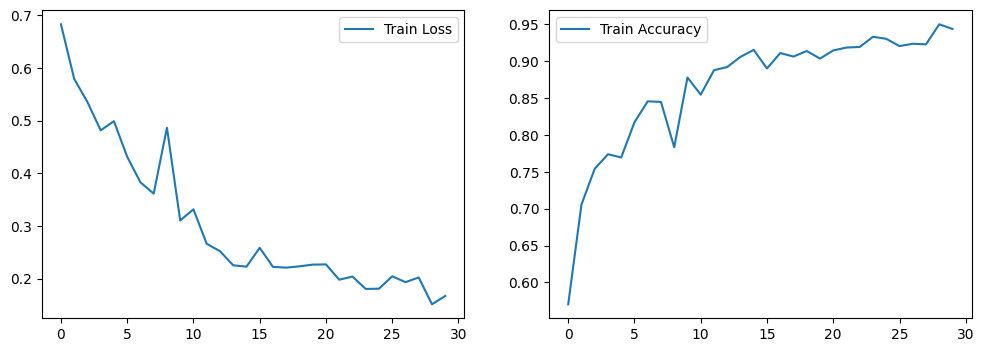

Gini Score (BatchNorm + Noise 0.5): 0.9787

=== BatchNorm + Noise 1 ===
Epoch 1/30 - Loss: 0.6969, Accuracy: 0.5343
Epoch 2/30 - Loss: 0.6491, Accuracy: 0.6085
Epoch 3/30 - Loss: 0.6359, Accuracy: 0.6448
Epoch 4/30 - Loss: 0.6062, Accuracy: 0.6677
Epoch 5/30 - Loss: 0.5505, Accuracy: 0.7253
Epoch 6/30 - Loss: 0.5236, Accuracy: 0.7470
Epoch 7/30 - Loss: 0.5092, Accuracy: 0.7541
Epoch 8/30 - Loss: 0.4628, Accuracy: 0.7924
Epoch 9/30 - Loss: 0.4157, Accuracy: 0.8287
Epoch 10/30 - Loss: 0.4440, Accuracy: 0.8066
Epoch 11/30 - Loss: 0.4500, Accuracy: 0.8051
Epoch 12/30 - Loss: 0.4032, Accuracy: 0.8370
Epoch 13/30 - Loss: 0.3858, Accuracy: 0.8410
Epoch 14/30 - Loss: 0.3355, Accuracy: 0.8666
Epoch 15/30 - Loss: 0.3499, Accuracy: 0.8556
Epoch 16/30 - Loss: 0.3644, Accuracy: 0.8575
Epoch 17/30 - Loss: 0.3961, Accuracy: 0.8311
Epoch 18/30 - Loss: 0.3360, Accuracy: 0.8642
Epoch 19/30 - Loss: 0.3341, Accuracy: 0.8725
Epoch 20/30 - Loss: 0.3169, Accuracy: 0.8733
Epoch 21/30 - Loss: 0.3967, Accuracy:

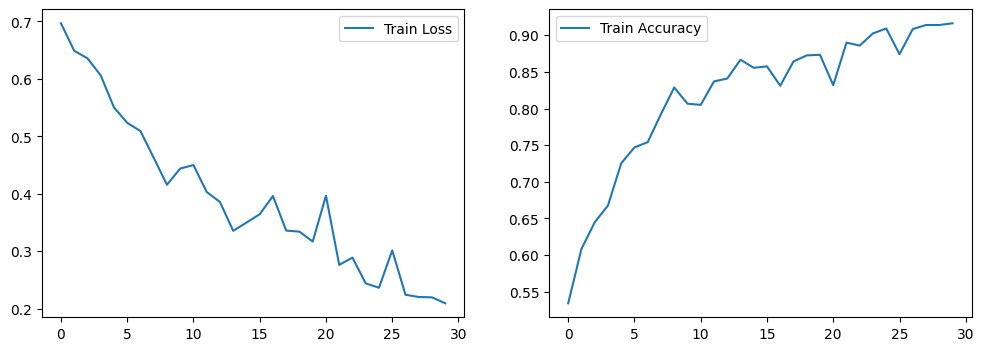

Gini Score (BatchNorm + Noise 1): 0.9674

=== BatchNorm + Noise 2 ===
Epoch 1/30 - Loss: 0.7309, Accuracy: 0.5185
Epoch 2/30 - Loss: 0.6891, Accuracy: 0.5328
Epoch 3/30 - Loss: 0.6789, Accuracy: 0.5663
Epoch 4/30 - Loss: 0.6430, Accuracy: 0.6255
Epoch 5/30 - Loss: 0.6146, Accuracy: 0.6646
Epoch 6/30 - Loss: 0.6033, Accuracy: 0.6721
Epoch 7/30 - Loss: 0.5509, Accuracy: 0.7309
Epoch 8/30 - Loss: 0.5207, Accuracy: 0.7640
Epoch 9/30 - Loss: 0.5060, Accuracy: 0.7668
Epoch 10/30 - Loss: 0.4695, Accuracy: 0.7936
Epoch 11/30 - Loss: 0.4458, Accuracy: 0.8007
Epoch 12/30 - Loss: 0.4141, Accuracy: 0.8224
Epoch 13/30 - Loss: 0.3830, Accuracy: 0.8473
Epoch 14/30 - Loss: 0.3741, Accuracy: 0.8583
Epoch 15/30 - Loss: 0.4331, Accuracy: 0.8220
Epoch 16/30 - Loss: 0.4298, Accuracy: 0.8149
Epoch 17/30 - Loss: 0.4029, Accuracy: 0.8327
Epoch 18/30 - Loss: 0.3358, Accuracy: 0.8666
Epoch 19/30 - Loss: 0.3510, Accuracy: 0.8646
Epoch 20/30 - Loss: 0.3565, Accuracy: 0.8512
Epoch 21/30 - Loss: 0.4365, Accuracy: 0

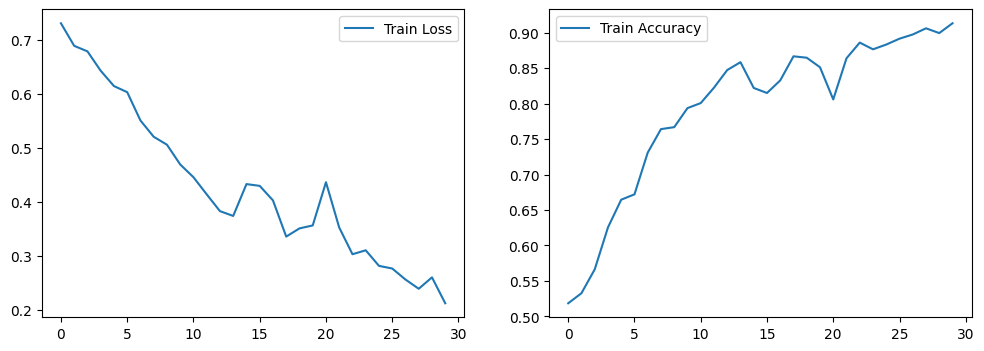

Gini Score (BatchNorm + Noise 2): 0.9340

=== BatchNorm ===
Epoch 1/30 - Loss: 0.6433, Accuracy: 0.6290
Epoch 2/30 - Loss: 0.5536, Accuracy: 0.7316
Epoch 3/30 - Loss: 0.5068, Accuracy: 0.7640
Epoch 4/30 - Loss: 0.4853, Accuracy: 0.7908
Epoch 5/30 - Loss: 0.4689, Accuracy: 0.8125
Epoch 6/30 - Loss: 0.4344, Accuracy: 0.8421
Epoch 7/30 - Loss: 0.3462, Accuracy: 0.8741
Epoch 8/30 - Loss: 0.3069, Accuracy: 0.8832
Epoch 9/30 - Loss: 0.2811, Accuracy: 0.8875
Epoch 10/30 - Loss: 0.2684, Accuracy: 0.8978
Epoch 11/30 - Loss: 0.3499, Accuracy: 0.8619
Epoch 12/30 - Loss: 0.2955, Accuracy: 0.8919
Epoch 13/30 - Loss: 0.2240, Accuracy: 0.9088
Epoch 14/30 - Loss: 0.2368, Accuracy: 0.9227
Epoch 15/30 - Loss: 0.1991, Accuracy: 0.9227
Epoch 16/30 - Loss: 0.1959, Accuracy: 0.9349
Epoch 17/30 - Loss: 0.1760, Accuracy: 0.9301
Epoch 18/30 - Loss: 0.1572, Accuracy: 0.9424
Epoch 19/30 - Loss: 0.1574, Accuracy: 0.9428
Epoch 20/30 - Loss: 0.1585, Accuracy: 0.9451
Epoch 21/30 - Loss: 0.1542, Accuracy: 0.9432
Epoc

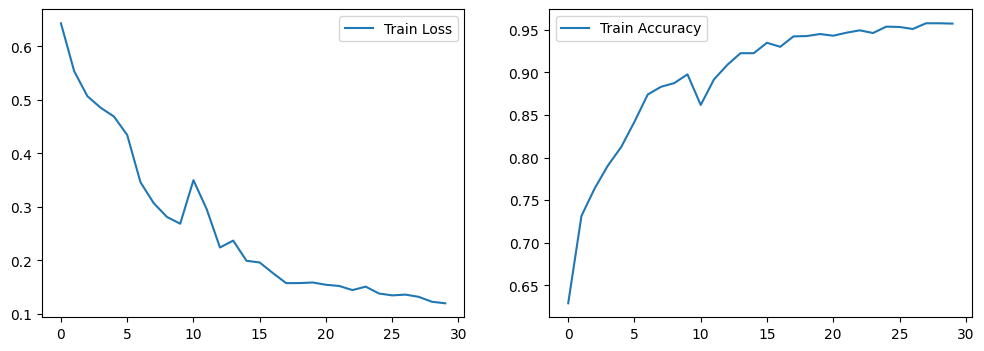

Gini Score (BatchNorm): 0.9815

=== No BatchNorm ===
Epoch 1/30 - Loss: 0.8957, Accuracy: 0.5201
Epoch 2/30 - Loss: 0.6410, Accuracy: 0.6405
Epoch 3/30 - Loss: 0.5573, Accuracy: 0.7167
Epoch 4/30 - Loss: 0.4974, Accuracy: 0.7680
Epoch 5/30 - Loss: 0.4606, Accuracy: 0.8027
Epoch 6/30 - Loss: 0.4246, Accuracy: 0.8260
Epoch 7/30 - Loss: 0.3891, Accuracy: 0.8477
Epoch 8/30 - Loss: 0.3533, Accuracy: 0.8627
Epoch 9/30 - Loss: 0.3841, Accuracy: 0.8536
Epoch 10/30 - Loss: 0.3666, Accuracy: 0.8536
Epoch 11/30 - Loss: 0.3044, Accuracy: 0.8840
Epoch 12/30 - Loss: 0.2741, Accuracy: 0.8923
Epoch 13/30 - Loss: 0.2614, Accuracy: 0.8966
Epoch 14/30 - Loss: 0.2485, Accuracy: 0.9009
Epoch 15/30 - Loss: 0.2217, Accuracy: 0.9061
Epoch 16/30 - Loss: 0.2248, Accuracy: 0.9053
Epoch 17/30 - Loss: 0.2108, Accuracy: 0.9159
Epoch 18/30 - Loss: 0.2109, Accuracy: 0.9152
Epoch 19/30 - Loss: 0.1775, Accuracy: 0.9321
Epoch 20/30 - Loss: 0.1801, Accuracy: 0.9301
Epoch 21/30 - Loss: 0.1845, Accuracy: 0.9325
Epoch 22/30

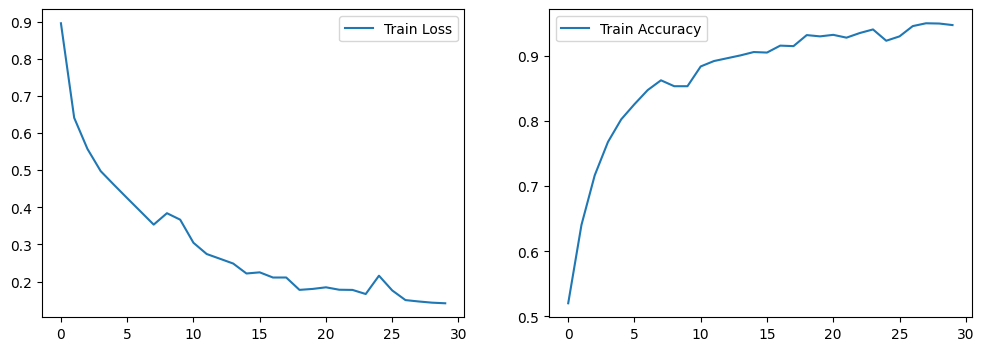

Gini Score (No BatchNorm): 0.9869


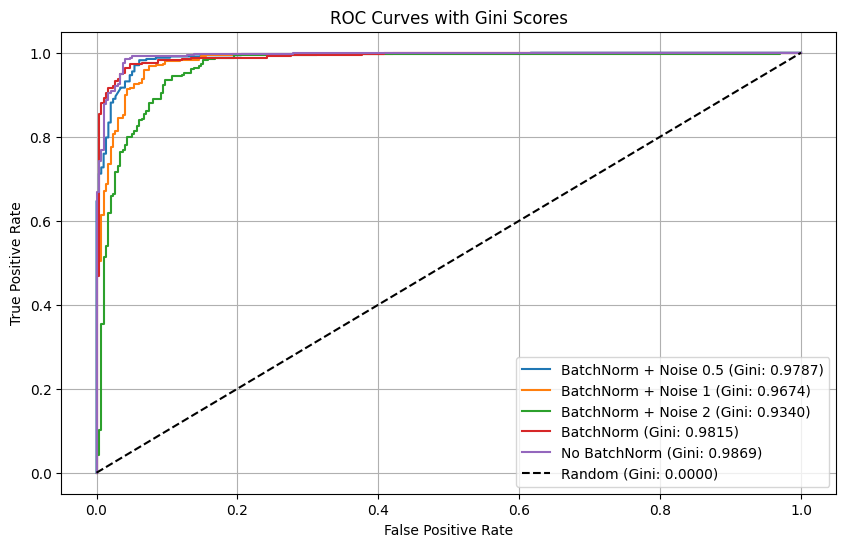

In [9]:
configs = [
    ("BatchNorm + Noise 0.5", True, 0.5),
    ("BatchNorm + Noise 1", True, 1),
    ("BatchNorm + Noise 2", True, 2),
    ("BatchNorm", True, 0.0),
    ("No BatchNorm", False, 0.0),
]

gini_results = []

for config_name, use_bn, noise_scale in configs:
    print(f"\n=== {config_name} ===")
    model = NeuralNetwork(input_size=X_train.shape[1], hidden_layer_1=16, hidden_layer_2=8, use_batch_norm=use_bn, noise_scale=noise_scale)
    model = train_model(model, train_loader, epochs=30, learning_rate=0.01)
    
    # Evaluation
    model.eval()
    y_true = []
    y_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_true.extend(y_batch.numpy().flatten())
            y_probs.extend(outputs.numpy().flatten())

    gini_score, fpr, tpr = compute_gini(y_true, y_probs)
    gini_results.append((config_name, gini_score, fpr, tpr))

    print(f"Gini Score ({config_name}): {gini_score:.4f}")

# ROC and Gini score
plt.figure(figsize=(10, 6))
for config_name, gini_score, fpr, tpr in gini_results:
    plt.plot(fpr, tpr, label=f"{config_name} (Gini: {gini_score:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random (Gini: 0.0000)")
plt.title("ROC Curves with Gini Scores")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()